# Assignment 3
## Question 1: Siamese networks & one-shot learning (8pt)
The Cifar-100 dataset is similar to the Cifar-10 dataset. It also consists of 60,000 32x32 RGB images, but they are distributed over 100 classes instead of 10. Thus, each class has much less examples, only 500 training images and 100 testing images per class. For more info about the dataset, see https://www.cs.toronto.edu/~kriz/cifar.html.

*HINT: Import the Cifar-100 dataset directly from Keras, no need to download it from the website. Use* `label_mode="fine"`

### Task 1.1: Siamese network
**a)**
* Train a Siamese Network on the first 80 classes of (the training set of) Cifar-100, i.e. let the network predict the probability that two input images are from the same class. Use 1 as a target for pairs of images from the same class (positive pairs), and 0 for pairs of images from different classes (negative pairs). Randomly select image pairs from Cifar-100, but make sure you train on as many positive pairs as negative pairs.

* Evaluate the performance of the network on 20-way one-shot learning tasks. Do this by generating 250 random tasks and obtain the average accuracy for each evaluation round. Use the remaining 20 classes that were not used for training. The model should perform better than random guessing.

For this question you may ignore the test set of Cifar-100; it suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

*HINT: First sort the data by their labels (see e.g.* `numpy.argsort()`*), then reshape the data to a shape of* `(n_classes, n_examples, width, height, depth)`*, similar to the Omniglot data in Practical 4. It is then easier to split the data by class, and to sample positive and negative images pairs for training the Siamese network.*

*NOTE: do not expect the one-shot accuracy for Cifar-100 to be similar to that accuracy for Omniglot; a lower accuracy can be expected. However, accuracy higher than random guess is certainly achievable.*

In [0]:
# For plotting
import matplotlib.pyplot as plt

# To download fashion mnist
from keras.datasets import cifar100

# To covert target (classes) into categorical vector
from keras.utils import to_categorical

# Keras backend as K
from keras import backend as K

# Numpy as np
import numpy as np
import pandas as pd

# OS operations (for file operations)
import os

# To perform the dimensionality reduction with Principal Component Analysis
from sklearn.decomposition import PCA

# For MLP
from keras.models import Sequential
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization

# For regularization
from keras.layers import Dropout, BatchNormalization
from keras.regularizers import l2

# For convolution
from keras.layers import Conv2D, MaxPooling2D

# For autoencoders
from keras.layers import UpSampling2D, Reshape
from keras import regularizers

# Extra imports
from sklearn.utils import shuffle
from keras.losses import binary_crossentropy

# For Task 1.2 only
from sklearn.neighbors import NearestNeighbors

In [10]:
################################################################################
################################# PREPARE DATA #################################
################################################################################

# load the data
# For CIFAR100 coarse labels are the superclass to which the image belongs to, 
# like: fish, flowers or insects. 
# Fine labels are the subclass, like: bee, beetle, butterfly, caterpillar...
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode = "fine")

# properties of the data
img_rows, img_cols, chns = 32, 32, 3 # 3 because RGB
n_classes = 100

# reshape
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

# normalise
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

# # transform labels to one-hot encoding, but also keep original single-digit encoding
y_train_digits = y_train
y_test_digits = y_test
y_train = to_categorical(y_train_digits, n_classes)
y_test = to_categorical(y_test_digits, n_classes)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 100)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 100)


In [0]:
# *HINT: First sort the data by their labels (see e.g.* `numpy.argsort()`*), 
# then reshape the data to a shape of* `(n_classes, n_examples, width, height, depth)`*, 
# similar to the Omniglot data in Practical 4. 
# It is then easier to split the data by class, and to sample positive and 
# negative images pairs for training the Siamese network.*

def getSortedLabels(isTestSet = False):
  """
  Return a tuple (indices, labels)
  """
  if isTestSet :
    y = y_test
    y_digits = y_test_digits
  else :
    y = y_train
    y_digits = y_train_digits

  indices = np.arange(len(y))
  indices_sorted = y_digits.copy().flatten()
  # We create a matrix where the first column is the label, the second the index
  indices_sorted = np.vstack((indices_sorted, indices)).T
  # Then we sort by label. i.e., the class 1 is first, the class 100 is last
  indices_sorted = indices_sorted[
      indices_sorted[:,0].argsort()]
  # We return first indices, then labels sorted. (as tuple)
  return indices_sorted[:,1], indices_sorted[:,0]


In [12]:
# Sort indices and labels
indices_sorted, labels_sorted = getSortedLabels()

# Get the x_train set sorted in the same way as the labels
x_train_sorted = x_train[indices_sorted]

# Then we reshape x_train as suggested
x_train_sorted = x_train_sorted.reshape((n_classes, 500, 32, 32, 3))

# We already have the labels sorted... though we do not need them
y_train_digits_sorted = labels_sorted
y_train_sorted = y_train[indices_sorted]

# Split the set into 2 parts: first 80 classes, last 20 classes
x_train_80 = x_train_sorted[:80]
x_train_20 = x_train_sorted[80:]
print("x_train shape : \t", x_train_sorted.shape)
print("x_train shape_80 : \t", x_train_80.shape)
print("x_train shape_20: \t", x_train_20.shape)
# show_img(1, x_train_sorted[19])

x_train shape : 	 (100, 500, 32, 32, 3)
x_train shape_80 : 	 (80, 500, 32, 32, 3)
x_train shape_20: 	 (20, 500, 32, 32, 3)


In [0]:
def get_batch(batch_size, X):
    """Create batch of n pairs, half same class, half different class"""
    # We read the sape components
    n_classes, n_examples, w, h, d = X.shape
    
    # randomly sample batch_size classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)

    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, d)) for i in range(2)]

    # initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = np.random.randint(0, n_examples)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(w, h, d)
        idx_2 = np.random.randint(0, n_examples)
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category
        else:
            #add a random number to the category mod n_classes to ensure 2nd image has different category
            category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        pairs[1][i, :, :, :] = X[category_2,idx_2].reshape(w, h, d)
    return pairs, targets

def batch_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, X)
        yield (pairs, targets)

def train(model, X_train, batch_size = 64, steps_per_epoch=100, epochs=1):
    model.fit_generator(batch_generator(batch_size, X_train), steps_per_epoch=steps_per_epoch, epochs=epochs)
    

In [14]:
left_input = Input(input_shape)
right_input = Input(input_shape)

# build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64, (3, 3), activation='relu', input_shape = input_shape, 
                   kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(128, (3,3), activation='relu'))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(256, (3,3), activation='relu'))
convnet.add(Flatten())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Dense(1024, activation="sigmoid", kernel_regularizer=l2(0.1)))
convnet.summary()

# encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# merge two encoded inputs with the L1 distance between them, and connect to prediction output layer
L1_distance = lambda x: K.abs(x[0]-x[1])
both = Lambda(L1_distance)([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(both)
siamese_net = Model(inputs=[left_input, right_input], outputs = prediction)


siamese_net.compile(loss = "binary_crossentropy", optimizer = "adam", 
                    metrics = ['acc'])

siamese_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 6, 128)         512       
__________

In [0]:
def make_oneshot_task(N, X):
    """Create pairs of (test image, support set image) with ground truth, for testing N-way one-shot learning."""
    
    # Get shape components
    n_classes, n_examples, w, h, d = X.shape
    # Create N random indices within a class, from [0, n_examples)
    indices = np.random.randint(0, n_examples, size=(N,))
    # Fill N different random uniform samples in the range of [0, n_classes)
    categories = np.random.choice(range(n_classes), size=(N,), replace=False)            
    # The first sample is my point of reference
    true_category = categories[0]
    # Create 2 random uniform samples from [0, n_examples)
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    # Get the ex1 in true_category, from X. N indentical samples.
    test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, d)
    # The support contains 1 element per each of the random categories
    support_set = X[categories, indices, :, :]
    # The first element of the support set is an image of the same true_category
    support_set[0, :, :] = X[true_category, ex2]
    # Reshape to N-images format
    support_set = support_set.reshape(N, w, h, d)
    
    # N zeros
    targets = np.zeros((N,))
    # image with itself is a 1 (true)
    targets[0] = 1
    # Shuffle together the targets, the test_images, and the support set.
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    # pairs of test_image, support_set
    pairs = [test_image, support_set]
    return pairs, targets

def test_oneshot(model, X, N=20, k=250, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    # we perform the evaluation k times
    for i in range(k):
        # Create N pairs. One pair is true, others are 0
        inputs, targets = make_oneshot_task(N, X)
        # Predict all inputs. We would expect at least one to be true.
        probs = model.predict(inputs)

        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    # Percetage from the k trials
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning".format(percent_correct, N))
    return percent_correct

In [0]:
loops = 200
best_acc = 0
best_loop = 0
for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    train(siamese_net, x_train_80, batch_size = 64, steps_per_epoch = 100, epochs = 1)
    test_acc = test_oneshot(siamese_net, x_train_20)
    if test_acc >= best_acc:
        best_acc = test_acc
        best_loop = i

print("Best accuracy obtained in loop {}: {}".format(best_loop, best_acc))


=== Training loop 1 ===
Epoch 1/1
100/100 [==============================] - 8s 81ms/step - loss: 13.1377 - acc: 0.5466
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 4.4% accuracy for 20-way one-shot learning
=== Training loop 2 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.9348 - acc: 0.5511
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.8% accuracy for 20-way one-shot learning
=== Training loop 3 ===
Epoch 1/1
 76/100 [=====================>........] - ETA: 1s - loss: 0.7762 - acc: 0.5374

100/100 [==============================] - 7s 66ms/step - loss: 0.7763 - acc: 0.5403
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 7.6% accuracy for 20-way one-shot learning
=== Training loop 4 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7834 - acc: 0.5542
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 5.2% accuracy for 20-way one-shot learning
=== Training loop 5 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7817 - acc: 0.5569
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.0% accuracy for 20-way one-shot learning
=== Training loop 6 ===
Epoch 1/1
  3/100 [..............................] - ETA: 6s - loss: 0.7917 - acc: 0.5312

100/100 [==============================] - 7s 66ms/step - loss: 0.7879 - acc: 0.5575
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 7 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7897 - acc: 0.5544
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 8 ===
Epoch 1/1
 93/100 [==========================>...] - ETA: 0s - loss: 0.7877 - acc: 0.5534

100/100 [==============================] - 7s 66ms/step - loss: 0.7872 - acc: 0.5522
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 9 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7917 - acc: 0.5689
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 10 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7975 - acc: 0.5625
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 11 ===
Epoch 1/1
  4/100 [>.............................] - ETA: 6s - loss: 0.8077 - acc: 0.5742

100/100 [==============================] - 7s 66ms/step - loss: 0.7855 - acc: 0.5698
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 12 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7853 - acc: 0.5636
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.8% accuracy for 20-way one-shot learning
=== Training loop 13 ===
Epoch 1/1
 98/100 [============================>.] - ETA: 0s - loss: 0.7884 - acc: 0.5620

100/100 [==============================] - 7s 66ms/step - loss: 0.7885 - acc: 0.5613
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 14 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7829 - acc: 0.5737
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.0% accuracy for 20-way one-shot learning
=== Training loop 15 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7873 - acc: 0.5641
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 7.6% accuracy for 20-way one-shot learning
=== Training loop 16 ===
Epoch 1/1
  9/100 [=>............................] - ETA: 6s - loss: 0.7981 - acc: 0.6042

100/100 [==============================] - 7s 66ms/step - loss: 0.7865 - acc: 0.5819
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.0% accuracy for 20-way one-shot learning
=== Training loop 17 ===
Epoch 1/1
100/100 [==============================] - 7s 67ms/step - loss: 0.7928 - acc: 0.5692
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 18 ===
Epoch 1/1
 92/100 [==========================>...] - ETA: 0s - loss: 0.7943 - acc: 0.5744

100/100 [==============================] - 7s 66ms/step - loss: 0.7927 - acc: 0.5758
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 19 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7934 - acc: 0.5739
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.8% accuracy for 20-way one-shot learning
=== Training loop 20 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7940 - acc: 0.5730
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 7.2% accuracy for 20-way one-shot learning
=== Training loop 21 ===
Epoch 1/1
  4/100 [>.............................] - ETA: 6s - loss: 0.8049 - acc: 0.5742

100/100 [==============================] - 7s 66ms/step - loss: 0.8020 - acc: 0.5683
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.8% accuracy for 20-way one-shot learning
=== Training loop 22 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.8111 - acc: 0.5666
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 23 ===
Epoch 1/1
 91/100 [==========================>...] - ETA: 0s - loss: 0.7970 - acc: 0.5695

100/100 [==============================] - 7s 66ms/step - loss: 0.7974 - acc: 0.5684
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 7.2% accuracy for 20-way one-shot learning
=== Training loop 24 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7996 - acc: 0.5900
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 25 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7932 - acc: 0.5709
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 26 ===
Epoch 1/1
  6/100 [>.............................] - ETA: 6s - loss: 0.7881 - acc: 0.5339

100/100 [==============================] - 7s 66ms/step - loss: 0.7913 - acc: 0.5759
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.8% accuracy for 20-way one-shot learning
=== Training loop 27 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7973 - acc: 0.5742
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.8% accuracy for 20-way one-shot learning
=== Training loop 28 ===
Epoch 1/1
 96/100 [===========================>..] - ETA: 0s - loss: 0.7993 - acc: 0.5666

100/100 [==============================] - 7s 66ms/step - loss: 0.7988 - acc: 0.5672
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 29 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7908 - acc: 0.5731
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 30 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7886 - acc: 0.5825
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 7.2% accuracy for 20-way one-shot learning
=== Training loop 31 ===
Epoch 1/1
  6/100 [>.............................] - ETA: 6s - loss: 0.7992 - acc: 0.6068

100/100 [==============================] - 7s 67ms/step - loss: 0.7928 - acc: 0.5856
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.0% accuracy for 20-way one-shot learning
=== Training loop 32 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7927 - acc: 0.5842
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.0% accuracy for 20-way one-shot learning
=== Training loop 33 ===
Epoch 1/1
 94/100 [===========================>..] - ETA: 0s - loss: 0.7970 - acc: 0.5708

100/100 [==============================] - 7s 66ms/step - loss: 0.7989 - acc: 0.5697
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.6% accuracy for 20-way one-shot learning
=== Training loop 34 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7904 - acc: 0.5791
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13.6% accuracy for 20-way one-shot learning
=== Training loop 35 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7905 - acc: 0.5711
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.4% accuracy for 20-way one-shot learning
=== Training loop 36 ===
Epoch 1/1
  6/100 [>.............................] - ETA: 6s - loss: 0.8010 - acc: 0.5781

100/100 [==============================] - 7s 66ms/step - loss: 0.7869 - acc: 0.5727
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13.6% accuracy for 20-way one-shot learning
=== Training loop 37 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7880 - acc: 0.5777
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.8% accuracy for 20-way one-shot learning
=== Training loop 38 ===
Epoch 1/1
 91/100 [==========================>...] - ETA: 0s - loss: 0.7798 - acc: 0.5778

100/100 [==============================] - 7s 66ms/step - loss: 0.7832 - acc: 0.5773
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 39 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7868 - acc: 0.5825
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13.2% accuracy for 20-way one-shot learning
=== Training loop 40 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7988 - acc: 0.5683
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.8% accuracy for 20-way one-shot learning
=== Training loop 41 ===
Epoch 1/1
  5/100 [>.............................] - ETA: 6s - loss: 0.8033 - acc: 0.5563

100/100 [==============================] - 7s 66ms/step - loss: 0.7920 - acc: 0.5752
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 42 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7864 - acc: 0.5717
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.6% accuracy for 20-way one-shot learning
=== Training loop 43 ===
Epoch 1/1
 94/100 [===========================>..] - ETA: 0s - loss: 0.7887 - acc: 0.5819

100/100 [==============================] - 7s 66ms/step - loss: 0.7883 - acc: 0.5817
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 44 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.8019 - acc: 0.5773
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 45 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7928 - acc: 0.5709
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 46 ===
Epoch 1/1
  4/100 [>.............................] - ETA: 6s - loss: 0.7318 - acc: 0.6367

100/100 [==============================] - 7s 67ms/step - loss: 0.8108 - acc: 0.5802
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.0% accuracy for 20-way one-shot learning
=== Training loop 47 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7863 - acc: 0.5891
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.8% accuracy for 20-way one-shot learning
=== Training loop 48 ===
Epoch 1/1
 94/100 [===========================>..] - ETA: 0s - loss: 0.7964 - acc: 0.5888

100/100 [==============================] - 7s 66ms/step - loss: 0.7974 - acc: 0.5858
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 49 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7946 - acc: 0.5848
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 7.6% accuracy for 20-way one-shot learning
=== Training loop 50 ===
Epoch 1/1
 98/100 [============================>.] - ETA: 0s - loss: 0.7926 - acc: 0.5730

100/100 [==============================] - 7s 66ms/step - loss: 0.7928 - acc: 0.5730
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.0% accuracy for 20-way one-shot learning
=== Training loop 51 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7851 - acc: 0.5864
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 52 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7826 - acc: 0.5802
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 53 ===
Epoch 1/1
  3/100 [..............................] - ETA: 6s - loss: 0.7978 - acc: 0.5573

100/100 [==============================] - 7s 66ms/step - loss: 0.7876 - acc: 0.5805
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 54 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7903 - acc: 0.5828
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 55 ===
Epoch 1/1
 97/100 [============================>.] - ETA: 0s - loss: 0.7865 - acc: 0.5726

100/100 [==============================] - 7s 66ms/step - loss: 0.7875 - acc: 0.5719
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 56 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7907 - acc: 0.5730
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 7.6% accuracy for 20-way one-shot learning
=== Training loop 57 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7802 - acc: 0.5752
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 58 ===
Epoch 1/1
  6/100 [>.............................] - ETA: 6s - loss: 0.7928 - acc: 0.5599

100/100 [==============================] - 7s 66ms/step - loss: 0.7952 - acc: 0.5795
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 59 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7767 - acc: 0.5727
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 60 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7894 - acc: 0.5891


Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 7.2% accuracy for 20-way one-shot learning
=== Training loop 61 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.8012 - acc: 0.5725
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 7.6% accuracy for 20-way one-shot learning
=== Training loop 62 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7897 - acc: 0.5891
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 63 ===
Epoch 1/1
 30/100 [========>.....................] - ETA: 4s - loss: 0.7767 - acc: 0.5818

100/100 [==============================] - 7s 66ms/step - loss: 0.7778 - acc: 0.5845
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.0% accuracy for 20-way one-shot learning
=== Training loop 64 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7813 - acc: 0.5863
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.0% accuracy for 20-way one-shot learning
=== Training loop 65 ===
Epoch 1/1
 99/100 [============================>.] - ETA: 0s - loss: 0.8020 - acc: 0.5682

100/100 [==============================] - 7s 66ms/step - loss: 0.8021 - acc: 0.5684
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 5.6% accuracy for 20-way one-shot learning
=== Training loop 66 ===
Epoch 1/1
100/100 [==============================] - 7s 67ms/step - loss: 0.7877 - acc: 0.5844
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 7.6% accuracy for 20-way one-shot learning
=== Training loop 67 ===
Epoch 1/1
 80/100 [=======================>......] - ETA: 1s - loss: 0.7947 - acc: 0.5756

100/100 [==============================] - 7s 66ms/step - loss: 0.7901 - acc: 0.5742
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 68 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7945 - acc: 0.5764
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 69 ===
Epoch 1/1
100/100 [==============================] - 7s 67ms/step - loss: 0.7961 - acc: 0.5731
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 16.8% accuracy for 20-way one-shot learning
=== Training loop 70 ===
Epoch 1/1
  2/100 [..............................] - ETA: 7s - loss: 0.8004 - acc: 0.5625

100/100 [==============================] - 7s 66ms/step - loss: 0.7937 - acc: 0.5728
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.0% accuracy for 20-way one-shot learning
=== Training loop 71 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7956 - acc: 0.5748
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.6% accuracy for 20-way one-shot learning
=== Training loop 72 ===
Epoch 1/1
 91/100 [==========================>...] - ETA: 0s - loss: 0.7939 - acc: 0.5749

100/100 [==============================] - 7s 67ms/step - loss: 0.7922 - acc: 0.5739
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.4% accuracy for 20-way one-shot learning
=== Training loop 73 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7908 - acc: 0.5959
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.0% accuracy for 20-way one-shot learning
=== Training loop 74 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7991 - acc: 0.5841
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13.2% accuracy for 20-way one-shot learning
=== Training loop 75 ===
Epoch 1/1
  6/100 [>.............................] - ETA: 6s - loss: 0.7659 - acc: 0.6016

100/100 [==============================] - 7s 66ms/step - loss: 0.7934 - acc: 0.5906
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 76 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.8054 - acc: 0.5847
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 77 ===
Epoch 1/1
 96/100 [===========================>..] - ETA: 0s - loss: 0.7998 - acc: 0.5864

100/100 [==============================] - 7s 66ms/step - loss: 0.8013 - acc: 0.5853
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.0% accuracy for 20-way one-shot learning
=== Training loop 78 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7936 - acc: 0.5905
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 79 ===
Epoch 1/1
100/100 [==============================] - 7s 67ms/step - loss: 0.7963 - acc: 0.5923
Evaluating model on 250 random 20-way one-shot learning tasks ...


Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 80 ===
Epoch 1/1
100/100 [==============================] - 7s 67ms/step - loss: 0.8021 - acc: 0.5962
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.0% accuracy for 20-way one-shot learning
=== Training loop 81 ===
Epoch 1/1
100/100 [==============================] - 7s 67ms/step - loss: 0.8013 - acc: 0.5831
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.8% accuracy for 20-way one-shot learning
=== Training loop 82 ===
Epoch 1/1
 49/100 [=============>................] - ETA: 3s - loss: 0.7947 - acc: 0.6008

100/100 [==============================] - 7s 65ms/step - loss: 0.8014 - acc: 0.6009
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.4% accuracy for 20-way one-shot learning
=== Training loop 83 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.8117 - acc: 0.5914
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.0% accuracy for 20-way one-shot learning
=== Training loop 84 ===
Epoch 1/1
 97/100 [============================>.] - ETA: 0s - loss: 0.8099 - acc: 0.5847

100/100 [==============================] - 7s 66ms/step - loss: 0.8107 - acc: 0.5852
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 85 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.8046 - acc: 0.5977
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.8% accuracy for 20-way one-shot learning
=== Training loop 86 ===
Epoch 1/1
100/100 [==============================] - 6s 64ms/step - loss: 0.8005 - acc: 0.5869
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.8% accuracy for 20-way one-shot learning
=== Training loop 87 ===
Epoch 1/1
  8/100 [=>............................] - ETA: 5s - loss: 0.7932 - acc: 0.5527

100/100 [==============================] - 7s 65ms/step - loss: 0.8008 - acc: 0.5927
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 88 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7999 - acc: 0.5941
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 89 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7924 - acc: 0.5903
Evaluating model on 250 random 20-way one-shot learning tasks ...


Got an average of 10.8% accuracy for 20-way one-shot learning
=== Training loop 90 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.8013 - acc: 0.5953
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 91 ===
Epoch 1/1
100/100 [==============================] - 7s 67ms/step - loss: 0.8029 - acc: 0.5931
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.4% accuracy for 20-way one-shot learning
=== Training loop 92 ===
Epoch 1/1
 51/100 [==============>...............] - ETA: 3s - loss: 0.7965 - acc: 0.5971

100/100 [==============================] - 6s 65ms/step - loss: 0.7962 - acc: 0.5925
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.8% accuracy for 20-way one-shot learning
=== Training loop 93 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7927 - acc: 0.5961
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 94 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7995 - acc: 0.5855
Evaluating model on 250 random 20-way one-shot learning tasks ...


Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 95 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.8080 - acc: 0.5953
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13.6% accuracy for 20-way one-shot learning
=== Training loop 96 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7950 - acc: 0.5864
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 97 ===
Epoch 1/1
 53/100 [==============>...............] - ETA: 3s - loss: 0.7850 - acc: 0.5802

100/100 [==============================] - 6s 65ms/step - loss: 0.7815 - acc: 0.5861
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 98 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7906 - acc: 0.5808
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.8% accuracy for 20-way one-shot learning
=== Training loop 99 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7853 - acc: 0.5958
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.4% accuracy for 20-way one-shot learning
=== Training loop 100 ===
Epoch 1/1
  3/100 [..............................] - ETA: 7s - loss: 0.7865 - acc: 0.6354

100/100 [==============================] - 6s 65ms/step - loss: 0.8038 - acc: 0.5808
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 101 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7823 - acc: 0.5848
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.0% accuracy for 20-way one-shot learning
=== Training loop 102 ===
Epoch 1/1
 96/100 [===========================>..] - ETA: 0s - loss: 0.7976 - acc: 0.5926

100/100 [==============================] - 6s 65ms/step - loss: 0.7988 - acc: 0.5931
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.0% accuracy for 20-way one-shot learning
=== Training loop 103 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7933 - acc: 0.5903
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.4% accuracy for 20-way one-shot learning
=== Training loop 104 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7823 - acc: 0.5878
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 105 ===
Epoch 1/1
  5/100 [>.............................] - ETA: 6s - loss: 0.7643 - acc: 0.5719

100/100 [==============================] - 7s 66ms/step - loss: 0.7860 - acc: 0.5831
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 106 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7788 - acc: 0.5941
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.4% accuracy for 20-way one-shot learning
=== Training loop 107 ===
Epoch 1/1
 97/100 [============================>.] - ETA: 0s - loss: 0.7863 - acc: 0.5915

100/100 [==============================] - 6s 65ms/step - loss: 0.7866 - acc: 0.5911
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 108 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7907 - acc: 0.5908
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.0% accuracy for 20-way one-shot learning
=== Training loop 109 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7868 - acc: 0.5981
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 110 ===
Epoch 1/1
  8/100 [=>............................] - ETA: 5s - loss: 0.8104 - acc: 0.6074

100/100 [==============================] - 6s 65ms/step - loss: 0.7967 - acc: 0.5881
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 111 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7948 - acc: 0.5825
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 112 ===
Epoch 1/1
 95/100 [===========================>..] - ETA: 0s - loss: 0.7898 - acc: 0.5947

100/100 [==============================] - 7s 66ms/step - loss: 0.7899 - acc: 0.5933
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 113 ===
Epoch 1/1
100/100 [==============================] - 6s 64ms/step - loss: 0.7918 - acc: 0.5891
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 114 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7877 - acc: 0.5938
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.0% accuracy for 20-way one-shot learning
=== Training loop 115 ===
Epoch 1/1
  4/100 [>.............................] - ETA: 6s - loss: 0.7448 - acc: 0.6328

100/100 [==============================] - 7s 66ms/step - loss: 0.7932 - acc: 0.5931
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.4% accuracy for 20-way one-shot learning
=== Training loop 116 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7975 - acc: 0.5839
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 117 ===
Epoch 1/1
 95/100 [===========================>..] - ETA: 0s - loss: 0.7896 - acc: 0.5888

100/100 [==============================] - 7s 66ms/step - loss: 0.7881 - acc: 0.5922
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 118 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7946 - acc: 0.5842
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 119 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7891 - acc: 0.5995
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.4% accuracy for 20-way one-shot learning
=== Training loop 120 ===
Epoch 1/1
  3/100 [..............................] - ETA: 6s - loss: 0.7887 - acc: 0.6198

100/100 [==============================] - 7s 65ms/step - loss: 0.7928 - acc: 0.5831
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13.6% accuracy for 20-way one-shot learning
=== Training loop 121 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7836 - acc: 0.5869
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.0% accuracy for 20-way one-shot learning
=== Training loop 122 ===
Epoch 1/1
 93/100 [==========================>...] - ETA: 0s - loss: 0.7886 - acc: 0.5968

100/100 [==============================] - 7s 65ms/step - loss: 0.7890 - acc: 0.5966
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.4% accuracy for 20-way one-shot learning
=== Training loop 123 ===
Epoch 1/1
100/100 [==============================] - 6s 64ms/step - loss: 0.7901 - acc: 0.5764
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.8% accuracy for 20-way one-shot learning
=== Training loop 124 ===
Epoch 1/1
100/100 [==============================] - 6s 64ms/step - loss: 0.7720 - acc: 0.5948
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 125 ===
Epoch 1/1
  7/100 [=>............................] - ETA: 6s - loss: 0.7441 - acc: 0.6094

100/100 [==============================] - 6s 65ms/step - loss: 0.7813 - acc: 0.5989
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.0% accuracy for 20-way one-shot learning
=== Training loop 126 ===
Epoch 1/1
100/100 [==============================] - 6s 64ms/step - loss: 0.7971 - acc: 0.5892
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 127 ===
Epoch 1/1
100/100 [==============================] - 6s 64ms/step - loss: 0.7860 - acc: 0.5866


Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 128 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7845 - acc: 0.5900
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 129 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7907 - acc: 0.5812
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 7.2% accuracy for 20-way one-shot learning
=== Training loop 130 ===
Epoch 1/1
 29/100 [=======>......................] - ETA: 4s - loss: 0.7922 - acc: 0.5808

100/100 [==============================] - 7s 65ms/step - loss: 0.7866 - acc: 0.5848
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.4% accuracy for 20-way one-shot learning
=== Training loop 131 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7921 - acc: 0.5889
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.8% accuracy for 20-way one-shot learning
=== Training loop 132 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7785 - acc: 0.6027


Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 133 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7768 - acc: 0.5991
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.4% accuracy for 20-way one-shot learning
=== Training loop 134 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.8039 - acc: 0.5769
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.8% accuracy for 20-way one-shot learning
=== Training loop 135 ===
Epoch 1/1
 28/100 [=======>......................] - ETA: 4s - loss: 0.7989 - acc: 0.5915

100/100 [==============================] - 6s 64ms/step - loss: 0.7885 - acc: 0.5837
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.8% accuracy for 20-way one-shot learning
=== Training loop 136 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7808 - acc: 0.6005
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.4% accuracy for 20-way one-shot learning
=== Training loop 137 ===
Epoch 1/1
 94/100 [===========================>..] - ETA: 0s - loss: 0.7732 - acc: 0.5918

100/100 [==============================] - 7s 65ms/step - loss: 0.7738 - acc: 0.5917
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 138 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7912 - acc: 0.5853
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.8% accuracy for 20-way one-shot learning
=== Training loop 139 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7927 - acc: 0.5977
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 140 ===
Epoch 1/1
  7/100 [=>............................] - ETA: 6s - loss: 0.7917 - acc: 0.5826

100/100 [==============================] - 6s 65ms/step - loss: 0.7927 - acc: 0.5828
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 141 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7924 - acc: 0.5891
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.4% accuracy for 20-way one-shot learning
=== Training loop 142 ===
Epoch 1/1
 95/100 [===========================>..] - ETA: 0s - loss: 0.7729 - acc: 0.6008

100/100 [==============================] - 7s 65ms/step - loss: 0.7741 - acc: 0.6008
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 143 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7859 - acc: 0.5863
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13.6% accuracy for 20-way one-shot learning
=== Training loop 144 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7927 - acc: 0.5908
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 145 ===
Epoch 1/1
  1/100 [..............................] - ETA: 7s - loss: 0.8034 - acc: 0.5469

100/100 [==============================] - 6s 65ms/step - loss: 0.7846 - acc: 0.5975
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 146 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7759 - acc: 0.5867
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 147 ===
Epoch 1/1
 94/100 [===========================>..] - ETA: 0s - loss: 0.7948 - acc: 0.5833

100/100 [==============================] - 6s 65ms/step - loss: 0.7956 - acc: 0.5866
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.8% accuracy for 20-way one-shot learning
=== Training loop 148 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7859 - acc: 0.5986
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 7.6% accuracy for 20-way one-shot learning
=== Training loop 149 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7921 - acc: 0.5938
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 150 ===
Epoch 1/1
  7/100 [=>............................] - ETA: 6s - loss: 0.7931 - acc: 0.6094

100/100 [==============================] - 6s 64ms/step - loss: 0.7892 - acc: 0.6053
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.4% accuracy for 20-way one-shot learning
=== Training loop 151 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7857 - acc: 0.6003
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.6% accuracy for 20-way one-shot learning
=== Training loop 152 ===
Epoch 1/1
 98/100 [============================>.] - ETA: 0s - loss: 0.7877 - acc: 0.5917

100/100 [==============================] - 6s 65ms/step - loss: 0.7867 - acc: 0.5922
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 153 ===
Epoch 1/1
100/100 [==============================] - 6s 64ms/step - loss: 0.7859 - acc: 0.5905
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.8% accuracy for 20-way one-shot learning
=== Training loop 154 ===
Epoch 1/1
100/100 [==============================] - 6s 64ms/step - loss: 0.7915 - acc: 0.5914
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 155 ===
Epoch 1/1
  8/100 [=>............................] - ETA: 6s - loss: 0.7874 - acc: 0.5879

100/100 [==============================] - 7s 65ms/step - loss: 0.7775 - acc: 0.5914
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 156 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7918 - acc: 0.5998
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 157 ===
Epoch 1/1
 94/100 [===========================>..] - ETA: 0s - loss: 0.7838 - acc: 0.5874

100/100 [==============================] - 7s 66ms/step - loss: 0.7833 - acc: 0.5881
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 16.4% accuracy for 20-way one-shot learning
=== Training loop 158 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7732 - acc: 0.5922
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.4% accuracy for 20-way one-shot learning
=== Training loop 159 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7860 - acc: 0.5881
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13.2% accuracy for 20-way one-shot learning
=== Training loop 160 ===
Epoch 1/1
  6/100 [>.............................] - ETA: 6s - loss: 0.7787 - acc: 0.5807

100/100 [==============================] - 7s 65ms/step - loss: 0.7763 - acc: 0.5953
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.0% accuracy for 20-way one-shot learning
=== Training loop 161 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7838 - acc: 0.5891
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.6% accuracy for 20-way one-shot learning
=== Training loop 162 ===
Epoch 1/1
 93/100 [==========================>...] - ETA: 0s - loss: 0.7788 - acc: 0.5840

100/100 [==============================] - 7s 66ms/step - loss: 0.7795 - acc: 0.5847
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 4.8% accuracy for 20-way one-shot learning
=== Training loop 163 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7646 - acc: 0.6070
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 164 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7793 - acc: 0.6002
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.4% accuracy for 20-way one-shot learning
=== Training loop 165 ===
Epoch 1/1
  5/100 [>.............................] - ETA: 6s - loss: 0.7981 - acc: 0.5844

100/100 [==============================] - 7s 65ms/step - loss: 0.7691 - acc: 0.5977
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.0% accuracy for 20-way one-shot learning
=== Training loop 166 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7712 - acc: 0.5952
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 167 ===
Epoch 1/1
 99/100 [============================>.] - ETA: 0s - loss: 0.7824 - acc: 0.5908

100/100 [==============================] - 6s 64ms/step - loss: 0.7824 - acc: 0.5908
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 168 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7809 - acc: 0.5925
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 169 ===
Epoch 1/1
 82/100 [=======================>......] - ETA: 1s - loss: 0.7722 - acc: 0.5991

100/100 [==============================] - 7s 65ms/step - loss: 0.7710 - acc: 0.6020
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 170 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7704 - acc: 0.5994
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 171 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7814 - acc: 0.5936
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 172 ===
Epoch 1/1
  5/100 [>.............................] - ETA: 6s - loss: 0.7997 - acc: 0.5156

100/100 [==============================] - 7s 66ms/step - loss: 0.7810 - acc: 0.5866
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 173 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7795 - acc: 0.5964
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.8% accuracy for 20-way one-shot learning
=== Training loop 174 ===
Epoch 1/1
 96/100 [===========================>..] - ETA: 0s - loss: 0.7879 - acc: 0.5881

100/100 [==============================] - 6s 65ms/step - loss: 0.7879 - acc: 0.5875
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.0% accuracy for 20-way one-shot learning
=== Training loop 175 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7824 - acc: 0.5894
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.8% accuracy for 20-way one-shot learning
=== Training loop 176 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7762 - acc: 0.6020
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 177 ===
Epoch 1/1
  2/100 [..............................] - ETA: 7s - loss: 0.7820 - acc: 0.5703

100/100 [==============================] - 7s 65ms/step - loss: 0.7870 - acc: 0.5942
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 178 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7807 - acc: 0.5986
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 179 ===
Epoch 1/1
 95/100 [===========================>..] - ETA: 0s - loss: 0.7831 - acc: 0.5962

100/100 [==============================] - 6s 64ms/step - loss: 0.7836 - acc: 0.5948
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 180 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7797 - acc: 0.5967
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.4% accuracy for 20-way one-shot learning
=== Training loop 181 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7696 - acc: 0.6106
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 182 ===
Epoch 1/1
  5/100 [>.............................] - ETA: 6s - loss: 0.8216 - acc: 0.5500

100/100 [==============================] - 7s 65ms/step - loss: 0.7799 - acc: 0.5977
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 5.6% accuracy for 20-way one-shot learning
=== Training loop 183 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7777 - acc: 0.5981
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.4% accuracy for 20-way one-shot learning
=== Training loop 184 ===
Epoch 1/1
 97/100 [============================>.] - ETA: 0s - loss: 0.7879 - acc: 0.5944

100/100 [==============================] - 7s 65ms/step - loss: 0.7873 - acc: 0.5962
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.8% accuracy for 20-way one-shot learning
=== Training loop 185 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7844 - acc: 0.5975
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.8% accuracy for 20-way one-shot learning
=== Training loop 186 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7910 - acc: 0.5852
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 187 ===
Epoch 1/1
  6/100 [>.............................] - ETA: 6s - loss: 0.7905 - acc: 0.6302

100/100 [==============================] - 7s 65ms/step - loss: 0.7948 - acc: 0.5964
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 188 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7805 - acc: 0.5880
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.0% accuracy for 20-way one-shot learning
=== Training loop 189 ===
Epoch 1/1
 96/100 [===========================>..] - ETA: 0s - loss: 0.7707 - acc: 0.6012

100/100 [==============================] - 7s 65ms/step - loss: 0.7706 - acc: 0.6009
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 190 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7680 - acc: 0.5989
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.2% accuracy for 20-way one-shot learning
=== Training loop 191 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7757 - acc: 0.5959
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.0% accuracy for 20-way one-shot learning
=== Training loop 192 ===
Epoch 1/1
  4/100 [>.............................] - ETA: 6s - loss: 0.7872 - acc: 0.6367

100/100 [==============================] - 7s 65ms/step - loss: 0.7694 - acc: 0.6031
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 193 ===
Epoch 1/1
100/100 [==============================] - 6s 64ms/step - loss: 0.7734 - acc: 0.5975
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 194 ===
Epoch 1/1
 96/100 [===========================>..] - ETA: 0s - loss: 0.7886 - acc: 0.5840

100/100 [==============================] - 7s 66ms/step - loss: 0.7893 - acc: 0.5858
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 195 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7763 - acc: 0.5950
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 196 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7680 - acc: 0.5866
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 197 ===
Epoch 1/1
  2/100 [..............................] - ETA: 7s - loss: 0.7401 - acc: 0.6406

100/100 [==============================] - 6s 65ms/step - loss: 0.7785 - acc: 0.5975
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 198 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7726 - acc: 0.5964
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.0% accuracy for 20-way one-shot learning
=== Training loop 199 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7686 - acc: 0.6009


Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 200 ===
Epoch 1/1
100/100 [==============================] - 7s 65ms/step - loss: 0.7622 - acc: 0.6008
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.0% accuracy for 20-way one-shot learning
Best accuracy obtained in loop 68: 16.8


***

**b)** Briefly motivate your model's architecture, as well as its performance. What accuracy would random guessing achieve (on average)?

**Answer:**

Since the accuracy is tested in the last 20 classes, the probabality of randomly guessing the correct class is `1/20 = 0.05`. 

The architecture is similar than the one has been built for the omniglot dataset with slightly different changes due to the different dimensions of the data. First, we have changed the dimensions of the kernels (filters) for the convoluational layers, by using a `3x3` size. In total we have applied 3 convulotional layers following a typical CNN architecture where for each layer we increase the number of units. At the last layer of each CNN we use a fully connected dense layer of 1024 neurons. Then, the two "legs" of the siamese network are measured witht the L1 distance. 

One can observe that the accuracy of the network on unseen data is somehow poor with a best measurement of `16.8`.

***

**c)** Compare the performance of your Siamese network for Cifar-100 to the Siamese network from Practical 4 for Omniglot. Name three fundamental differences between the Cifar-100 and Omniglot datasets. How do these differences influence the difference in one-shot accuracy?

**Answer:**

The accuracy of a similar siamese network in the Omniglot dataset is more than `80%`, while in Cifar-100 the best we could get is `16.8`. 

Three main difference between the datasets are:
 - Cifar-100 contains twice the number of classes than Omniglot
 - Cifar-100 has 6000 samples per class while Omniglot has only 1623 (around 2/3 less)
 - The domain of the images for Cifar-100 is much more complex. This is, it contains too many colors, shapes and even channels. On the other hand, Onmiglot is simplier and the differences between classes can be learned better. 

***

### Task 1.2: One-shot learning with neural codes
**a)**
* Train a CNN classifier on the first 80 classes of Cifar-100. Make sure it achieves at least 40% classification accuracy on those 80 classes (use the test set to validate this accuracy).
* Then use neural codes from one of the later hidden layers of the CNN with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.

In [0]:
# Sort indices and labels
# indices_sorted, labels_sorted = getSortedLabels()

# Get the x_train set sorted in the same way as the labels
indices_sorted = np.argsort(y_train_digits.flatten())
x_train_sorted = x_train[indices_sorted]
y_train_digits_sorted = y_train_digits[indices_sorted]#labels_sorted
y_train_sorted = y_train[indices_sorted]
x_train_80 = x_train_sorted[:40000]
x_train_20 = x_train_sorted[40000:]
y_train_80 = y_train_sorted[:40000][:, :80]
y_train_20 = y_train_sorted[40000:][:, 80:]

x_train_80, y_train_80 = shuffle(x_train_80, y_train_80)
x_train_20, y_train_20 = shuffle(x_train_20, y_train_20)

print("x_train shape : \t", x_train_sorted.shape)
print("x_train shape_80 : \t", x_train_80.shape)
print("x_train shape_20: \t", x_train_20.shape)

# Then we reshape x_train as suggested
# x_train_sorted = x_train_sorted.reshape((n_classes, 500, 32, 32, 3))

# indices_sorted, labels_sorted = getSortedLabels(True)
indices_sorted = np.argsort(y_test_digits.flatten())
# Get the x_train set sorted in the same way as the labels
x_test_sorted = x_test[indices_sorted]
y_test_digits_sorted = y_test_digits[indices_sorted]
y_test_sorted = y_test[indices_sorted]
x_test_80 = x_test_sorted[:8000]
x_test_20 = x_test_sorted[8000:]
y_test_80 = y_test_sorted[:8000][:, :80]
y_test_20 = y_test_sorted[8000:][:, 80:]

x_test_80, y_test_80 = shuffle(x_test_80, y_test_80)
x_test_20, y_test_20 = shuffle(x_test_20, y_test_20)

print("\nx_test shape : \t\t", x_test_sorted.shape)
print("x_test shape_80 : \t", x_test_80.shape)
print("x_test shape_20: \t", x_test_20.shape)


x_train shape : 	 (50000, 32, 32, 3)
x_train shape_80 : 	 (40000, 32, 32, 3)
x_train shape_20: 	 (10000, 32, 32, 3)

x_test shape : 		 (10000, 32, 32, 3)
x_test shape_80 : 	 (8000, 32, 32, 3)
x_test shape_20: 	 (2000, 32, 32, 3)


In [16]:
n_labelled_classes = 80
n_last_dense = 128

cnn = Sequential()

# === SOLUTION: ===
cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape = input_shape))
cnn.add(MaxPooling2D())
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128, (3,3), activation='relu'))#, #padding = "same", 
cnn.add(MaxPooling2D())
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128, (3,3), activation='relu'))
cnn.add(Flatten())
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))
cnn.add(Dense(1024, activation="sigmoid", name = "neural_codes"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Dense(n_labelled_classes, activation='softmax'))

cnn.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

cnn.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 6, 6, 128)         512       
__________

In [0]:
batch_size = 128
epochs = 15

cnn.fit(x_train_80, y_train_80,
          batch_size = batch_size,
          epochs=epochs,
          validation_data = (x_test_80, y_test_80))

Train on 40000 samples, validate on 8000 samples
Epoch 1/15
40000/40000 [==============================] - 15s 386us/step - loss: 3.9933 - acc: 0.1518 - val_loss: 3.7286 - val_acc: 0.1681
Epoch 2/15
40000/40000 [==============================] - 14s 352us/step - loss: 3.0164 - acc: 0.2721 - val_loss: 2.7262 - val_acc: 0.3132
Epoch 3/15
18432/40000 [============>.................] - ETA: 7s - loss: 2.6342 - acc: 0.3330

40000/40000 [==============================] - 14s 348us/step - loss: 2.5893 - acc: 0.3430 - val_loss: 2.8990 - val_acc: 0.3005
Epoch 4/15
40000/40000 [==============================] - 14s 348us/step - loss: 2.3356 - acc: 0.3957 - val_loss: 2.2645 - val_acc: 0.4213
Epoch 5/15
39808/40000 [============================>.] - ETA: 0s - loss: 2.1557 - acc: 0.4305

40000/40000 [==============================] - 14s 348us/step - loss: 2.1569 - acc: 0.4303 - val_loss: 2.2045 - val_acc: 0.4291
Epoch 6/15
40000/40000 [==============================] - 14s 350us/step - loss: 2.0186 - acc: 0.4567 - val_loss: 2.4888 - val_acc: 0.3835
Epoch 7/15
40000/40000 [==============================] - 14s 349us/step - loss: 1.9095 - acc: 0.4843 - val_loss: 2.1716 - val_acc: 0.4410
Epoch 8/15
 2944/40000 [=>............................] - ETA: 12s - loss: 1.7285 - acc: 0.5190

40000/40000 [==============================] - 14s 349us/step - loss: 1.8115 - acc: 0.5037 - val_loss: 2.1208 - val_acc: 0.4517
Epoch 9/15
40000/40000 [==============================] - 14s 351us/step - loss: 1.7267 - acc: 0.5262 - val_loss: 2.0526 - val_acc: 0.4685
Epoch 10/15
35968/40000 [=========================>....] - ETA: 1s - loss: 1.6570 - acc: 0.5390

40000/40000 [==============================] - 14s 350us/step - loss: 1.6647 - acc: 0.5375 - val_loss: 2.0893 - val_acc: 0.4566
Epoch 11/15
40000/40000 [==============================] - 14s 349us/step - loss: 1.5981 - acc: 0.5513 - val_loss: 1.9330 - val_acc: 0.4953
Epoch 12/15
40000/40000 [==============================] - 14s 351us/step - loss: 1.5380 - acc: 0.5686 - val_loss: 1.9696 - val_acc: 0.4913
Epoch 13/15
 1920/40000 [>.............................] - ETA: 12s - loss: 1.3043 - acc: 0.6255

40000/40000 [==============================] - 14s 349us/step - loss: 1.4823 - acc: 0.5798 - val_loss: 1.9784 - val_acc: 0.4935
Epoch 14/15
40000/40000 [==============================] - 14s 348us/step - loss: 1.4450 - acc: 0.5901 - val_loss: 2.4005 - val_acc: 0.4125
Epoch 15/15
35840/40000 [=========================>....] - ETA: 1s - loss: 1.3928 - acc: 0.6019

40000/40000 [==============================] - 14s 352us/step - loss: 1.4016 - acc: 0.6001 - val_loss: 2.0909 - val_acc: 0.4739


In [0]:
loss, accuracy = cnn.evaluate(x_test_80, y_test_80, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 2.328828109741211
Test accuracy: 0.408875


In [0]:
# Get last hidden layer 
neural_codes_output = Model([cnn.layers[0].input], 
                                 [cnn.get_layer("neural_codes").output])

# Reshape test set
x_test_20r = x_test_20.reshape((20, 100, 32, 32, 3))


Accuracy is 2.0%


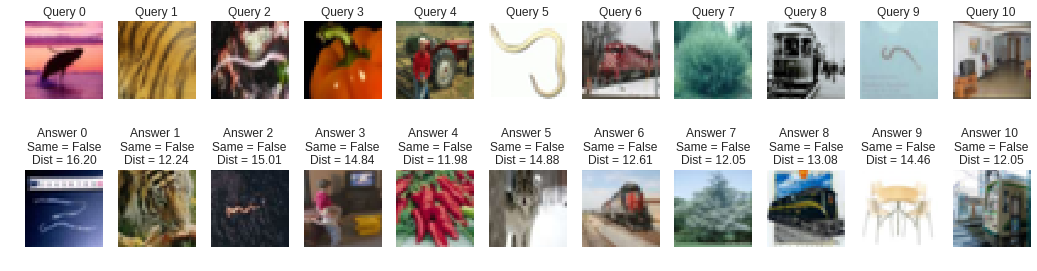

In [0]:

# Number of queries
n_queries = 250 # as in one shot task of task 1.1

to_show = 11

# Make nice canvas for plotting
fig, axes = plt.subplots(nrows = 2, ncols = to_show)
fig.set_size_inches(18, 5)

count_correct = 0
# For each trial...
for trial in range(n_queries):
  # Get the one-shot task
  pairs, targets = make_oneshot_task(20, x_test_20r)

  # Get the correspondant test_set and support_set
  test_set = pairs[0]
  support_set = pairs[1]

  tests_embeddings = neural_codes_output([ test_set ])[0]
  features_space = neural_codes_output([ support_set ])[0]

  # p = 2  is equivalent to L2 as indicated in the sklearn documentation
  nn = NearestNeighbors(n_neighbors = 1, metric = "l2").fit( features_space )

  # The test_set has the query image repated N times.
  query = test_set[0]

  # These is the embedding we obtained from the neural codes
  query_embedding = tests_embeddings[0]
  distances, indices = nn.kneighbors([ query_embedding ])
  nearest_index = indices[0][0] # Get the nearest neighbor
  distance = distances[0][0]
  answer_image = support_set[nearest_index]
  answer_target = bool(targets[nearest_index])
  
  if answer_target :
    count_correct += 1
    
  if trial < to_show :
    # Print the query
    axes[0][trial].imshow(query)
    axes[0][trial].set_title("Query {}".format(trial))
    axes[0][trial].axis("off")

    # Print the retrieved image
    axes[1][trial].imshow(answer_image)
    axes[1][trial].set_title("Answer {} \nSame = {}\nDist = {:.2f}".format(trial, 
                                                              answer_target, distance))
    axes[1][trial].axis("off")

print("Accuracy is {}%".format((count_correct/n_queries)*100))

***

**b)** Briefly motivate your CNN architecture, and discuss the difference in one-shot accuracy between the Siamese network approach and the CNN neural codes approach.

**Answer:**

Our CNN architecture follows a simplier approach than the convolutional components of the Siamase Network. We use the same number of neurons in the last dense layer as we made in the siamase network to have a fair comparison of the quality of the embeddings. 

We can see that with the CNN approach tested on the last 20 classes we see a very poor average accuracy, however, while visualizing some of the queries in a) we observe that for some of them the nearest neighbor does not belong to the same class but it is somehow similar. This may be due to the high number of classes of the dataset where many similar objects may be classified differently. However, even if senseful, this is still a poor accuracy for an stric one-shot task.